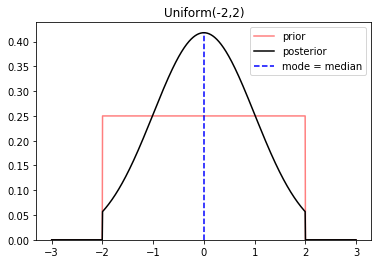

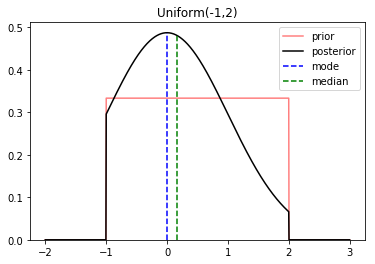

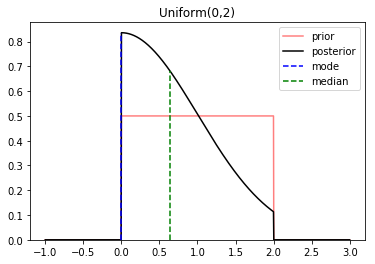

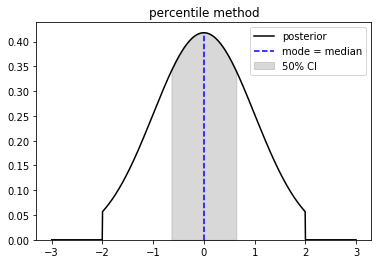

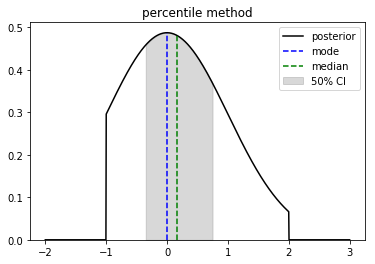

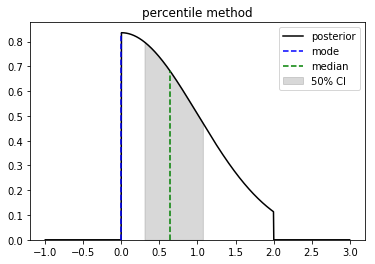

C:\Users\Jennifer\Miniconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log



acceptance rate = 48.6%
--> sample = [y/n]... n


TypeError: 'NoneType' object is not iterable

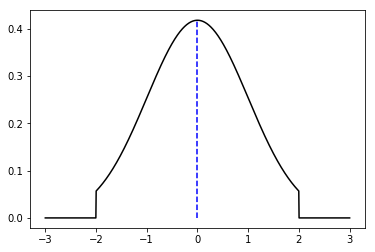

In [2]:
import numpy as np
from numba import jit
import torch,scipy
from scipy import stats as sp
from matplotlib import pylab as plt


def HDR(sort,target):
    # Add...
    # --> Highest Density Region (HDR)
    # To...
    # --> ax
    # |    p    : distr(sample)
    # | density : p[HDR] = density
    
    f = target(sort) # --> p
    cut = np.where(f<np.percentile(f,50))
    f[cut] = None # remove for plot
    plt.fill_between(sort,f,alpha=0.3,color='grey',label="50% CI")


def histogram(sample,n,k):
    # Add...
    # --> Histogram
    # To... ax
    # | k : #bins
    #   --> 'auto'
    #   --> int
    
    @jit(nopython=True)
    def bins(sort,h): # bins
        plot,histo,j = np.zeros((2,k)),np.zeros(k),0
        for x in sort: # iterate over sorted sample
            if x > sort[0]+(j+1)*h+10**-6: # new bin
                plot[0][j] = sort[0]+j*h
                plot[1][j] = sort[0]+(j+1)*h
                j += 1
            histo[j] += 1
        plot[0][-1] = sort[0]+(k-1)*h
        plot[1][-1] = sort[0]+k*h
        histo /= (n*h)
        return plot,histo
        
    # histogram
    if k == 'auto': k = int(min(n,10*np.log(n)/np.log(10)))
    sort = np.sort(sample)
    h = (sort[-1]-sort[0])/k # equal binwidth
    plot,histo = bins(sort,h) # --> bins
    # visualization
    plt.bar(0.5*(plot[0]+plot[1]),histo,h,color="yellow",alpha=0.5,label="Metropolis distribution")
    plt.plot([plot[0],plot[0]],[np.zeros(k),histo],alpha=0.5,color="orange")
    plt.plot([plot[1],plot[1]],[np.zeros(k),histo],alpha=0.5,color="orange")
    plt.plot([plot[0],plot[1]],[histo,histo],alpha=0.5,color="orange")
    

def KDE(sample,n,h,ax):
    # Add...
    # --> Kernel Density Estimation
    # To... ax
    # | h : bandwidth
    #   --> 'auto'
    #   --> float
    device = torch.device('cpu')
    
    def kernel(t): # Gaussian
        return torch.exp(-0.5*t**2)/(2*np.pi)**0.5
    
    # preprocessing
    data = torch.from_numpy(sample).to(device)
    mini,maxi = data.min(),data.max()
    std = data.std()
    if h == 'auto': h = (4/(3*n))**0.2*std # assumption : Gaussian data
    if n <= 10**5: chunk = 1000 # full batch
    else: chunk = int(10**5/n*1000) # mini batch
    Ibatch = [i for i in range(0,1000,chunk)]
    Ibatch.append(1000)
    
    # visualization
    plot = torch.linspace(mini,maxi,1000,dtype=torch.double).to(device).unsqueeze(1)
    f = torch.cat([kernel((plot[Ibatch[i]:Ibatch[i+1]]-data)/h).sum(1) for i in range(len(Ibatch)-1)])/(n*h)
    f,plot = f.cpu().cpu().numpy(),plot[:,0].cpu().numpy()
    ax.plot(plot,f,color='blue',label="MCMC distribution")


def ACF(series,mean,sos,lag):
    # Return...
    # --> Autocorrelation Function
    # --> Of... series
    # | assumption : stationarity
    if lag == 0: return 1
    else: return np.sum((series[:-lag]-mean)*(series[lag:]-mean))/sos
    
    
def Metropolis(target,n,sigma2,autocorr):
    # Return...
    # --> sample ~ target of size n
    # Via... Metropolis algorithm
    # |  sigma2  : control acceptance rate
    # | autocorr : lag for desired max autocorrelation
    
    #@jit(nopytho=True)
    def proposal(z): # generate candidate (random walk)
        return np.random.normal(z,sigma2**0.5)
    
    #@jit(nopython=True)
    def MCMC(proposal,m,z): # generate sample of size m
        # | z : initial state
        sample,accept = np.zeros(m+1),0
        sample[0] = z
        for i in range(m): # iterate over m states
            candidate = proposal(sample[i]) # --> proposal
            alpha = np.log(target(candidate))-np.log(target(sample[i])) # --> target
            u = np.log(np.random.uniform(0,1))
            if u <= alpha: # accept
                sample[i+1] = candidate
                accept += 1
            else: # reject
                sample[i+1] = sample[i]
        return sample[1:],accept/m
    
    # Metropolis algorithm
    z = np.random.normal(0,1) # init
    burn_in,accept = MCMC(proposal,10**4,z) # --> MCMC
    sampling = input("\nacceptance rate = "+str(round(100*accept,1))+"%\n--> sample = [y/n]... ")
    if sampling == 'y': # proceed
        # autocorrelation
        ACFplot,mean = [],burn_in[5000:].mean()
        lag,sos = 0,np.sum((burn_in[5000:]-mean)**2)
        while True: # calcuclate ACF with lag k
            ACFplot.append(ACF(burn_in[5000:],mean,sos,lag)) # --> ACF
            if abs(ACFplot[-1]) < autocorr: break
            else: lag += 1
        # sampling
        sample,accept = MCMC(proposal,n*lag,burn_in[-1]) # --> MCMC
        return sample[::lag],accept
    else: return None
    
    
# Bayesian inference

plot = np.linspace(-3,3,1000)
plt.plot(plot,sp.uniform.pdf(plot,-2,4),alpha=0.5,color='red',label="prior")
plt.plot(plot,sp.truncnorm.pdf(plot,-2,2),color='black',label='posterior')
plt.plot([0,0],[0,sp.truncnorm.pdf(0,-2,2)],"--",color="blue",label="mode = median")
plt.title("Uniform(-2,2)"),plt.legend(),plt.ylim(0),plt.show()

plot = np.linspace(-2,3,1000)
plt.plot(plot,sp.uniform.pdf(plot,-1,3),alpha=0.5,color='red',label="prior")
plt.plot(plot,sp.truncnorm.pdf(plot,-1,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(-1,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,-1,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,-1,2)],"--",color="green",label="median")
plt.title("Uniform(-1,2)"),plt.legend(),plt.ylim(0),plt.show()

plot = np.linspace(-1,3,1000)
plt.plot(plot,sp.uniform.pdf(plot,0,2),alpha=0.5,color='red',label="prior")
plt.plot(plot,sp.truncnorm.pdf(plot,0,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(0,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,0,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,0,2)],"--",color="green",label="median")
plt.title("Uniform(0,2)"),plt.legend(),plt.ylim(0),plt.show()


# percentile method

plot = np.linspace(-3,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,-2,2),color='black',label='posterior')
plt.plot([0,0],[0,sp.truncnorm.pdf(0,-2,2)],"--",color="blue",label="mode = median")
p1,p2 = sp.truncnorm.ppf([0.25,0.75],-2,2)
plot = np.linspace(p1,p2,1000)
plt.fill_between(plot,0,sp.truncnorm.pdf(plot,-2,2),alpha=0.3,color="grey",label='50% CI')
plt.title("percentile method"),plt.legend(),plt.ylim(0),plt.show()

plot = np.linspace(-2,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,-1,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(-1,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,-1,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,-1,2)],"--",color="green",label="median")
p1,p2 = sp.truncnorm.ppf([0.25,0.75],-1,2)
plot = np.linspace(p1,p2,1000)
plt.fill_between(plot,0,sp.truncnorm.pdf(plot,-1,2),alpha=0.3,color="grey",label='50% CI')
plt.title("percentile method"),plt.legend(),plt.ylim(0),plt.show()

plot = np.linspace(-1,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,0,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(0,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,0,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,0,2)],"--",color="green",label="median")
p1,p2 = sp.truncnorm.ppf([0.25,0.75],0,2)
plot = np.linspace(p1,p2,1000)
plt.fill_between(plot,0,sp.truncnorm.pdf(plot,0,2),alpha=0.3,color="grey",label='50% CI')
plt.title("percentile method"),plt.legend(),plt.ylim(0),plt.show()


# highest density region

plot = np.linspace(-3,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,-2,2),color='black',label='posterior')
plt.plot([0,0],[0,sp.truncnorm.pdf(0,-2,2)],"--",color="blue",label="mode = median")
def target(z): return sp.truncnorm.pdf(z,-2,2)
sample,accept = Metropolis(target,10**4,4,0.1) # --> Metropolis
HDR(np.sort(sample),target) # --> HDR
plt.title("highest density region"),plt.legend(),plt.ylim(0),plt.show()

plot = np.linspace(-2,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,-1,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(-1,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,-1,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,-1,2)],"--",color="green",label="median")
def target(z): return sp.truncnorm.pdf(z,-1,2)
sample,accept = Metropolis(target,10**4,4,0.1) # --> Metropolis
HDR(np.sort(sample),target) # --> HDR
plt.title("highest density region"),plt.legend(),plt.ylim(0),plt.show()

plot = np.linspace(-1,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,0,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(0,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,0,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,0,2)],"--",color="green",label="median")
def target(z): return sp.truncnorm.pdf(z,0,2)
sample,accept = Metropolis(target,10**4,4,0.1) # --> Metropolis
HDR(np.sort(sample),target) # --> HDR
plt.title("highest density region"),plt.legend(),plt.ylim(0),plt.show()


# noisy target

def target(z): return sp.truncnorm.pdf(z,-2,2)*np.random.normal(8,2)
sample,accept = Metropolis(target,10**4,4,0.1) # --> Metropolis
sort = np.sort(sample)
histogram(sort,10**4,15) # --> histo
plot = np.linspace(-3,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,-2,2),color="black",label="true target")
plt.title("MCMC"),plt.legend(),plt.show()
plot = np.linspace(-3,3,1000)
noisy = [target(t) for t in plot]
plt.scatter(plot,noisy,s=1,color='red',label='noise ~ N(8,2)')
plt.title("noisy target"),plt.legend(),plt.show()
plt.plot(plot,sp.truncnorm.pdf(plot,-2,2),color='black',label='posterior')
plt.plot([0,0],[0,sp.truncnorm.pdf(0,-2,2)],"--",color="blue",label="mode = median")
def target(z): return sp.truncnorm.pdf(z,-2,2)
HDR(sort,target) # --> HDR
plt.title("highest density region"),plt.legend(),plt.ylim(0),plt.show()


def target(z): return sp.truncnorm.pdf(z,-1,2)*np.random.normal(8,2)
sample,accept = Metropolis(target,10**4,4,0.1) # --> Metropolis
sort = np.sort(sample)
histogram(sort,10**4,15) # --> histo
plot = np.linspace(-2,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,-1,2),color="black",label="true target")
plt.title("MCMC"),plt.legend(),plt.show()
plot = np.linspace(-2,3,1000)
noisy = [target(t) for t in plot]
plt.scatter(plot,noisy,s=1,color='red',label='noise ~ N(8,2)')
plt.title("noisy target"),plt.legend(),plt.show()
plt.plot(plot,sp.truncnorm.pdf(plot,-1,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(-1,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,-1,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,-1,2)],"--",color="green",label="median")
def target(z): return sp.truncnorm.pdf(z,-1,2)
HDR(sort,target) # --> HDR
plt.title("highest density region"),plt.legend(),plt.ylim(0),plt.show()


def target(z): return sp.truncnorm.pdf(z,0,2)*np.random.normal(8+z,2)
sample,accept = Metropolis(target,10**4,4,0.1) # --> Metropolis
sort = np.sort(sample)
histogram(sort,10**4,15) # --> histo
plot = np.linspace(-1,3,1000)
plt.plot(plot,sp.truncnorm.pdf(plot,0,2),color="black",label="true target")
plt.title("MCMC"),plt.legend(),plt.show()
plot = np.linspace(-1,3,1000)
noisy = [target(t) for t in plot]
plt.scatter(plot,noisy,s=1,color='red',label='noise ~ N(8+z,2)')
plt.title("noisy target"),plt.legend(),plt.show()
plt.plot(plot,sp.truncnorm.pdf(plot,0,2),color='black',label='posterior')
mode,median = 0,sp.truncnorm.median(0,2)
plt.plot([mode,mode],[0,sp.truncnorm.pdf(mode,0,2)],"--",color="blue",label="mode")
plt.plot([median,median],[0,sp.truncnorm.pdf(median,0,2)],"--",color="green",label="median")
def target(z): return sp.truncnorm.pdf(z,0,2)
HDR(sort,target) # --> HDR
plt.title("highest density region"),plt.legend(),plt.ylim(0),plt.show()